In [1]:
# untar
!tar -xvzf dataset.tar.gz

train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


In [2]:
import os
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from copy import deepcopy

from matplotlib import pyplot as plt

%matplotlib inline

print(tf.version.VERSION)

2.12.0


In [3]:
# load train
train_images = pickle.load(open("../train_images.pkl", "rb"))
train_labels = pickle.load(open("../train_labels.pkl", "rb"))

# load val
val_images = pickle.load(open("../val_images.pkl", "rb"))
val_labels = pickle.load(open("../val_labels.pkl", "rb"))


In [4]:
def measure_sparsity(weights):
    num_zeros = 0
    num_nonzeros = 0
    for weight in weights:
        z = tf.math.count_nonzero(tf.equal(weight, 0)).numpy()
        nz = tf.size(weight).numpy() - z
        num_zeros += z
        num_nonzeros += nz

    return num_zeros / (num_zeros + num_nonzeros)

In [5]:
def calc_std(weights):
    tmp = []
    for w in weights:
        tmp.append(w.numpy().flatten())
    oned_stackedweights = np.hstack(tmp)
    return np.std(oned_stackedweights)


def prune(weights, stdval, factor=1):
    pruned_weights = deepcopy(weights)
    threshold = stdval * factor
    for i, w in enumerate(pruned_weights):
        mask = tf.cast(tf.greater(
            tf.abs(w), threshold), tf.float32)
        pruned_weights[i] = (tf.multiply(w, mask))
    return pruned_weights

In [6]:
def prune(model, factor=0.5, dense_thresh=None):
    pruned_weights = []
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Conv2D):
            weights, biases = layer.get_weights()
            w = deepcopy(weights)
            b = deepcopy(biases)
        
            l1_norms = np.sum(np.abs(w), axis=(0, 1, 2))
            l1_norms_sorted_indices = np.argsort(l1_norms)[::-1]
            tot = len(l1_norms_sorted_indices)
            cutoff = round(factor * tot)
            w[:, :, :, l1_norms_sorted_indices[-cutoff:]] = 0.0
            b[l1_norms_sorted_indices[-cutoff:]] = 0

            pruned_weights.append(w)
            pruned_weights.append(b)
        
        elif isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            w = deepcopy(weights)
            b = deepcopy(biases)

            if dense_thresh is not None:
                mask = tf.cast(tf.greater(
                    tf.abs(w), dense_thresh), tf.float32)
                w = tf.multiply(w, mask)

            pruned_weights.append(w)
            pruned_weights.append(b)

    return pruned_weights

In [7]:
model = keras.models.load_model("../unpruned_val_acc_0.7493.h5")
unpruned_weights_std = calc_std(model.trainable_weights)


for i in range(10):
    pruned_weights = prune(model, factor=0.8, dense_thresh=3 * unpruned_weights_std)
    model.set_weights(pruned_weights)

    checkpoint_path = f"l1norm_pruning_itr_{i}.h5"

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1,
        monitor="val_accuracy"
    )

    model.fit(
        x=train_images, 
        y=train_labels,
        epochs=50, 
        batch_size=128, 
        validation_data=(val_images, val_labels),
        callbacks=[cp_callback]
    )

    val_loss, val_acc = model.evaluate(val_images, val_labels)
    sparsity = measure_sparsity(model.trainable_weights)

    print(f"Sparsity: {sparsity} | val loss: {val_loss} | val acc: {val_acc}")


Epoch 1/50
176/176 [==============================] - ETA: 0s - loss: 1.5941 - accuracy: 0.2493
Epoch 1: saving model to l1norm_pruning_itr_0.h5
176/176 [==============================] - 13s 12ms/step - loss: 1.5941 - accuracy: 0.2493 - val_loss: 1.5657 - val_accuracy: 0.2737
Epoch 2/50
173/176 [============================>.] - ETA: 0s - loss: 1.5531 - accuracy: 0.2996
Epoch 2: saving model to l1norm_pruning_itr_0.h5
176/176 [==============================] - 2s 9ms/step - loss: 1.5530 - accuracy: 0.3000 - val_loss: 1.5302 - val_accuracy: 0.3164
Epoch 3/50
175/176 [============================>.] - ETA: 0s - loss: 1.5283 - accuracy: 0.3212
Epoch 3: saving model to l1norm_pruning_itr_0.h5
176/176 [==============================] - 2s 9ms/step - loss: 1.5280 - accuracy: 0.3213 - val_loss: 1.4998 - val_accuracy: 0.3438
Epoch 4/50
171/176 [============================>.] - ETA: 0s - loss: 1.4971 - accuracy: 0.3470
Epoch 4: saving model to l1norm_pruning_itr_0.h5
176/176 [================

79/79 [==============================] - 1s 12ms/step - loss: 0.8798 - accuracy: 0.6570


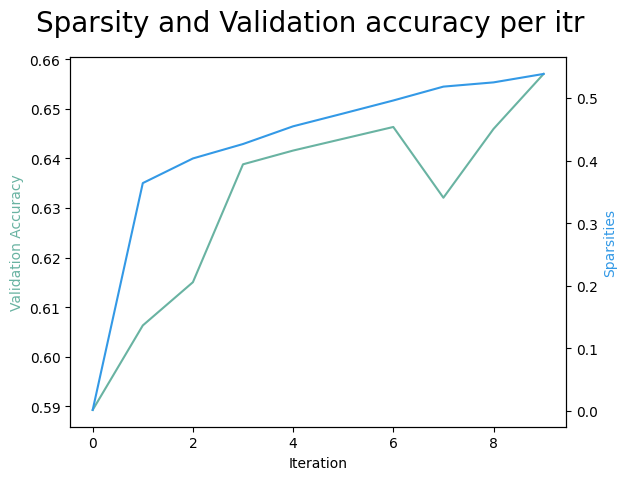

: 

In [12]:
model = keras.models.load_model("../unpruned_val_acc_0.7493.h5")

saved_res_files = sorted([file for file in os.listdir() if file.endswith(".h5")])

sparsities = []
val_accs = []

for file in saved_res_files:
  model.load_weights(file)
  val_loss, val_acc = model.evaluate(val_images, val_labels)
  sparsity = measure_sparsity(model.trainable_weights)
  sparsities.append(sparsity)
  val_accs.append(val_acc)
                    
itrs = list(range(len(saved_res_files)))

COLOR_VAL_ACC = "#69b3a2"
COLOR_SPARSITY = "#3399e6"

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(itrs, val_accs, color=COLOR_VAL_ACC)
ax2.plot(itrs, sparsities, color=COLOR_SPARSITY)


fig.suptitle("Sparsity and Validation accuracy per itr", fontsize=20)

ax1.set_xlabel("Iteration")

ax1.set_ylabel("Validation Accuracy", color=COLOR_VAL_ACC)
ax2.set_ylabel("Sparsities", color=COLOR_SPARSITY)

plt.show()

In [13]:
model = keras.models.load_model("../unpruned_val_acc_0.7493.h5")
model_path = "l1norm_pruning_itr_8.h5"
model.load_weights(model_path)

final_results = model.evaluate(val_images, val_labels)
final_model_sparsity = measure_sparsity(model.trainable_weights)

print(f"Post retraining val loss: {final_results[0]} | val acc: {final_results[1]} | sparsity: {final_model_sparsity}")

79/79 [==============================] - 0s 3ms/step - loss: 0.8866 - accuracy: 0.6459
Post retraining val loss: 0.8865513801574707 | val acc: 0.6459406018257141 | sparsity: 0.524732136683234


In [9]:
model = keras.models.load_model("../unpruned_val_acc_0.7493.h5")
unpruned_weights = deepcopy(model.trainable_weights)

factors = np.linspace(0.1, 1, num=20)

val_loss, val_acc = model.evaluate(val_images, val_labels)

val_losses = [val_loss]
val_accuracies = [val_acc]
sparsities = [0]

for factor in factors:
    pruned_weights = prune(model, factor=factor, dense_thresh=None)
    model.set_weights(pruned_weights)
    
    val_loss, val_acc = model.evaluate(val_images, val_labels)
    sparsity = measure_sparsity(model.trainable_weights)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    sparsities.append(sparsity)
    
    print(f"Factor: {factor} | Sparsity: {sparsity} | val loss: {val_loss} | val acc: {val_acc}")
    model.set_weights(unpruned_weights)


79/79 [==============================] - 1s 12ms/step - loss: 1.7902 - accuracy: 0.6063
Factor: 0.1 | Sparsity: 0.010367107244832047 | val loss: 1.7902100086212158 | val acc: 0.6063366532325745
79/79 [==============================] - 1s 12ms/step - loss: 2.2447 - accuracy: 0.5061
Factor: 0.1473684210526316 | Sparsity: 0.015817976061376242 | val loss: 2.2446749210357666 | val acc: 0.5061386227607727
79/79 [==============================] - 1s 12ms/step - loss: 3.6074 - accuracy: 0.4004
Factor: 0.19473684210526315 | Sparsity: 0.020734214489664095 | val loss: 3.6073758602142334 | val acc: 0.40039604902267456
79/79 [==============================] - 1s 12ms/step - loss: 4.0369 - accuracy: 0.3667
Factor: 0.24210526315789474 | Sparsity: 0.02618508330620829 | val loss: 4.0368523597717285 | val acc: 0.3667326867580414
79/79 [==============================] - 1s 12ms/step - loss: 3.5300 - accuracy: 0.2931
Factor: 0.2894736842105263 | Sparsity: 0.03256185774783998 | val loss: 3.5300498008728027

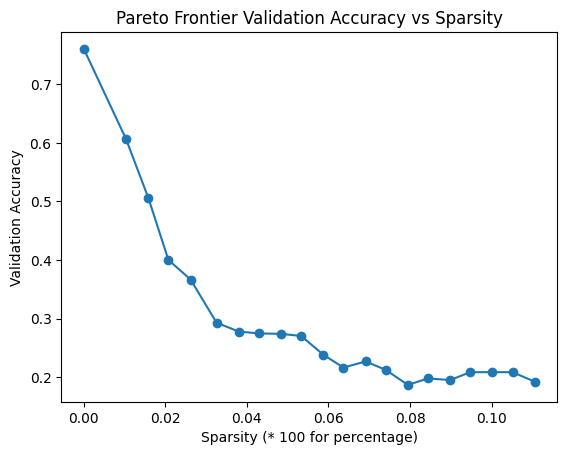

In [11]:
fig, axes = plt.subplots()
axes.plot(sparsities, val_accuracies, marker="o")
axes.set_title("Pareto Frontier Validation Accuracy vs Sparsity")
axes.set_xlabel("Sparsity (* 100 for percentage)")
axes.set_ylabel("Validation Accuracy")

plt.show()